In [1]:
!pip install -q corner kepler.py

## Data

[Apparently](https://www.aanda.org/articles/aa/pdf/2019/02/aa33273-18.pdf) Gaia reports RV error $\epsilon$ defined as:

$$
\epsilon^2 = \left(\sqrt{\frac{\pi}{2\,N}}\,s\right)^2 + 0.11^2
$$

where

$$
s^2 = \frac{1}{N-1}\sum_{n=1}^N \left(v_n - \bar{v}\right)^2
$$

is what we actually want.

## Model

We need to compute a probability density for the $s^2$ parameter above conditioned on a set of $N$ noisy observations of an RV orbit (with some given parameters).
I'm going to model the noise as Gaussian with a known, constant variance $\sigma^2$, but it's *possible* (although probably tricky) that we could relax some of that.

Next, the key realization is that if we have a set of $N$ Gaussian random variables $X_n \sim \mathcal{N}\left(\mu_n,\,\sigma^2\right)$ (with known, but different, means $\mu_n$, in our case given by the RV orbit evaluated at $t_n$), then the random variable $Y = \sum X_n^2$ will be distributed as a [noncentral chi-squared](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution).
To use this to our advantage, we first argue that the argument in the variance sum $v_n - \bar{v}$ will be a Gaussian random variable

$$
v_n - \bar{v} \sim \mathcal{N}\left(\mu_n - \bar{\mu},\,\sigma^2\right)
$$

where $\mu_n$ is the RV orbit *model* at time $t_n$.
This isn't totally obvious since the $v_n$ and $\bar{v}$ distributions aren't necessarily independent, but I think it's ok because [insert relevant math here] (this derivation will look similar to the sampling distirbution for the sample variance calculations so I should double check there, but this definitely works in practice).

Then we're where we need to be: $(N - 1)\,s^2$, our quantity of interest, is now the sum of squares of $N$ Gaussian random variables.
Following [the Wikipedia page for the noncentral chi-squared distribution](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution), we need to rescale our parameters to have unit variance:

$$
\frac{v_n - \bar{v}}{\sigma} \sim \mathcal{N}\left(\frac{v_n - \bar{\mu}}{\sigma},\,1\right)
$$

where we have used the assumption that $\sigma$ is known and constant.
I think that we could allow non-constant $\sigma$ but that would result in a ["generalized chi-squared" distribution which has no closed form](https://en.wikipedia.org/wiki/Generalized_chi-squared_distribution).

Then the parameters of our noncentral chi-squared will be

$$
k = N
$$

and

$$
\lambda = \sum \frac{N\,(\mu_n - \bar{\mu})^2}{(1 + N)\,\sigma^2}
$$

And the parameter that is thus distributed is:

$$
\xi^2 = \frac{(N - 1)\,s^2}{\sigma^2}
$$

## Is the math right?

That was a bit ugly.
Let's see if this works with a simulation.
We'll simulate a single simple RV curve and then compute the distribution of $s^2$ over many different realizations of the noise.

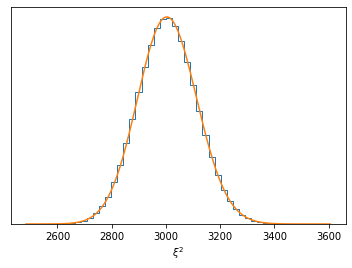

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# Simulate the RV curve
np.random.seed(721)
N = 50
sigma = 0.9
t = np.random.uniform(0, 600, N)
true_period = 175.0
true_phase = 0.323
true_semiamp = 10.0
y_true = true_semiamp * np.sin(2 * np.pi * t / true_period + true_phase)

# Generate many realization of the noise and compute the statistic
sims = y_true[None, :] + sigma * np.random.randn(5000000, N)
sim_s2 = np.var(sims, axis=1, ddof=1)
xi2 = (N - 1) * sim_s2 / sigma ** 2

# Compute the parameters of the noncentral chi-squared as above
# Note: that this is only a function of the model, not the realization
lam = np.sum((y_true - np.mean(y_true)) ** 2) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=N, nc=lam)

_, bins, _ = plt.hist(xi2, 50, histtype="step", density=True)
x = np.linspace(bins.min(), bins.max(), 500)
plt.plot(x, ncx2.pdf(x))
plt.yticks([])
plt.xlabel(r"$\xi^2$");

Boom. Looking good.

## So. What can we learn from this?

Now, let's try fitting this "dataset".
In this example, for simplicity I'll just use a circular orbit with parameters: period $P$, phase $\phi$, and semi-amplitude $K$.

In [15]:
np.random.seed(722)

# Compute the "dataset"
data = np.var(y_true + sigma * np.random.randn(N), ddof=1)

# Sample many parameters from the prior
n_samp = 5000000
log_period = np.random.uniform(np.log10(10.0), np.log10(5000.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(8.0), np.log(12.0), n_samp)

# Construct the RV model for each sample
mod = np.exp(log_semiamp) * np.sin(2 * np.pi * t[:, None] * 10 ** -log_period + phase)

# Then compute the likelihood for each model
lam = np.sum((mod - np.mean(mod, axis=0))**2, axis=0) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=N, nc=lam)
log_like = ncx2.logpdf((N - 1) * data / sigma ** 2)

Moment of truth: how do these constraints look?

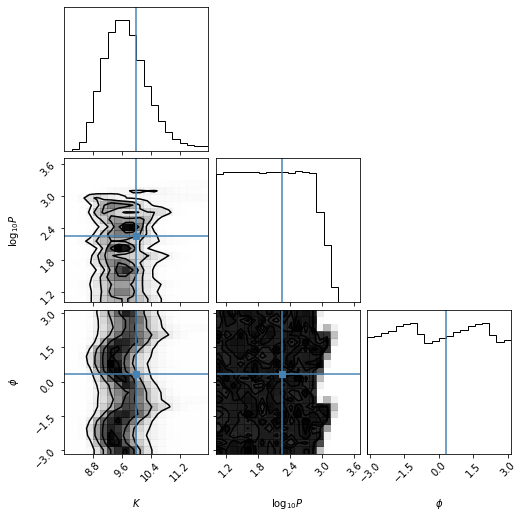

In [16]:
import corner
corner.corner(
    np.stack((np.exp(log_semiamp), log_period, phase)).T,
    weights=np.exp(log_like - log_like.max()),
    plot_datapoints=False,
    truths=[true_semiamp, np.log10(true_period), true_phase],
    labels=["$K$", "$\log_{10} P$", r"$\phi$"]
);

Interesting! It looks like we get our prior back for period and phase.
Not surprising? It is a little for me, but maybe it makes sense since this is a circular orbit?

There is some interesting structure in the $K-P$-plane. Perhaps we can learn something from that?

But: we get a nice constaint on the semi-amplitude.
Let's zoom in on that:

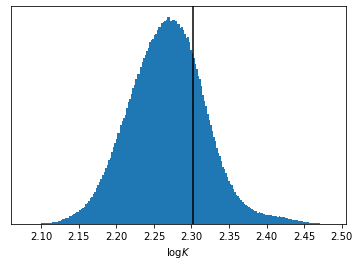

In [5]:
plt.hist(log_semiamp, 200, weights=np.exp(log_like - log_like.max()))
plt.axvline(np.log(true_semiamp), color="k")
plt.yticks([])
plt.xlabel(r"$\log K$");

Cool!

Now let's ask the question: does knowing the times actually help?

I'm going to try running this again, but generating random times in the model instead of using the correct times.

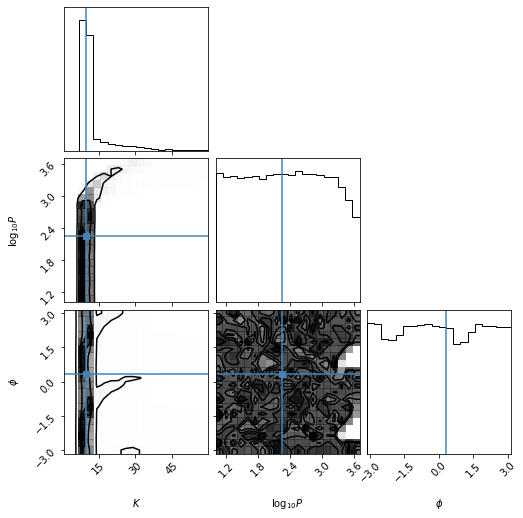

In [18]:
np.random.seed(723)

# Compute the "dataset"
data = np.var(y_true + sigma * np.random.randn(N), ddof=1)

# Sample many parameters from the prior
n_samp = 5000000
log_period = np.random.uniform(np.log10(10.0), np.log10(5000.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(1.0), np.log(60.0), n_samp)

# Construct the RV model for each sample
mod = np.exp(log_semiamp) * np.sin(2 * np.pi * np.random.uniform(0, 600, (N, n_samp)) * 10 ** -log_period + phase)

# Then compute the likelihood for each model
lam = np.sum((mod - np.mean(mod, axis=0))**2, axis=0) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=N, nc=lam)
log_like = ncx2.logpdf((N - 1) * data / sigma ** 2)

corner.corner(
    np.stack((np.exp(log_semiamp), log_period, phase)).T,
    weights=np.exp(log_like - log_like.max()),
    plot_datapoints=False,
    truths=[true_semiamp, np.log10(true_period), true_phase],
    labels=["$K$", "$\log_{10} P$", r"$\phi$"]
);

Looks like it doesn't make much difference, but maybe that's because I simulated the times randomly anyways?

## Realistic eccentric orbits

Now what about an eccentric orbit?
Let's simulate a very eccentric orbit:

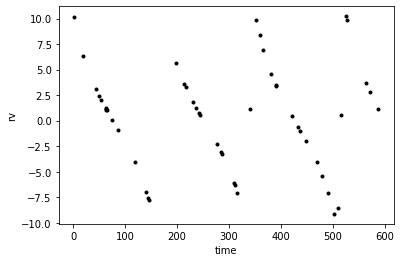

In [19]:
import kepler

true_omega = -1.5
true_ecc = 0.7
cosw = np.cos(true_omega)
sinw = np.sin(true_omega)

true_M = 2 * np.pi * t / true_period + true_phase
_, cosf, sinf = kepler.kepler(true_M, true_ecc)
true_rv = true_semiamp * (cosw * (true_ecc + cosf) - sinw * sinf)
plt.plot(t, true_rv, ".k")
plt.xlabel("time")
plt.ylabel("rv");

And then run essentially the same modeling code on it (with fewer samples so that I don't run out of RAM on colab):

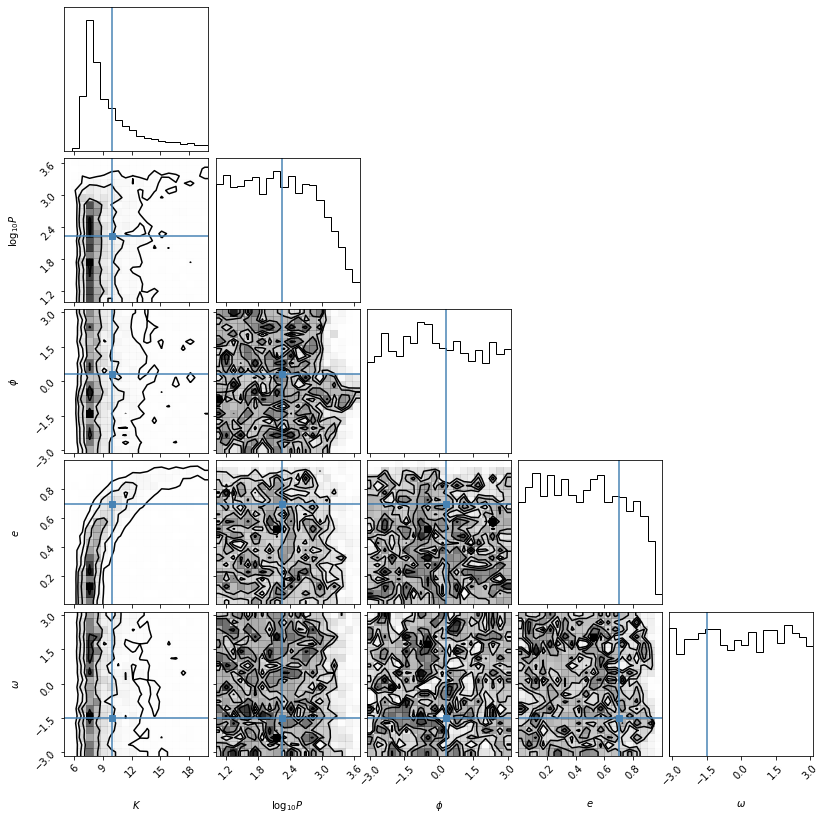

In [22]:
np.random.seed(726)

# Compute the "dataset"
data = np.var(true_rv + sigma * np.random.randn(N), ddof=1)

# Sample many parameters from the prior
n_samp = 100000
log_period = np.random.uniform(np.log10(10.0), np.log10(5000.0), n_samp)
phase = np.random.uniform(-np.pi, np.pi, n_samp)
log_semiamp = np.random.uniform(np.log(5.0), np.log(20.0), n_samp)
ecc = np.random.uniform(0, 1, n_samp)
omega = np.random.uniform(-np.pi, np.pi, n_samp)

# Construct the RV model for each sample
cosw = np.cos(omega)
sinw = np.sin(omega)
M = 2 * np.pi * t * 10 ** -log_period[:, None] + phase[:, None]
_, cosf, sinf = kepler.kepler(M, ecc[:, None] + np.zeros_like(M))
mod = np.exp(log_semiamp[:, None]) * (cosw[:, None] * (ecc[:, None] + cosf) - sinw[:, None] * sinf)

# Then compute the likelihood for each model
lam = np.sum((mod - np.mean(mod, axis=1)[:, None])**2, axis=1) / sigma ** 2
ncx2 = scipy.stats.ncx2(df=N, nc=lam)
log_like = ncx2.logpdf((N - 1) * data / sigma ** 2)

corner.corner(
    np.stack((np.exp(log_semiamp), log_period, phase, ecc, omega)).T,
    weights=np.exp(log_like - log_like.max()),
    plot_datapoints=False,
    truths=[true_semiamp, np.log10(true_period), true_phase, true_ecc, true_omega],
    labels=["$K$", "$\log_{10} P$", r"$\phi$", "$e$", r"$\omega$"]
);

Again, we get nice constaints on the semi-amplitude, but sadly not much else.